In [50]:
import glob

import numpy as np
import scipy.stats as stats
import pandas as pd

%matplotlib inline
import matplotlib.sankey
import matplotlib.pyplot as plt
import matplotlib.ticker as tick
from matplotlib import cm

from matplotlib.dates import DateFormatter

# Handle date time conversions between pandas and matplotlib
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

#from IPython.display import set_matplotlib_formats
#set_matplotlib_formats('svg') # set it here to 'png' or 'svg'

import seaborn as sns
#sns.set()
# Use white grid plot background from seaborn
sns.set(style="whitegrid")


## Data loading & pre-processing

In [2]:
DATES = ["15 Jun","16 Jun","17 Jun","18 Jun","21 Jun","22 Jun","23 Jun","24 Jun","25 Jun","29 Jun","30 Jun","01 Jun","02 Jun"]
DATE_FORMATTER = tick.FuncFormatter(lambda x,p: DATES[x])

In [3]:
actions = pd.concat((pd.read_csv(f) for f in sorted(glob.glob("logs-2021-*/actions.csv"))))

people = pd.concat((pd.read_csv(f) for f in sorted(glob.glob("logs-2021-*/people.csv"))))

children = pd.concat((pd.read_csv(f) for f in sorted(glob.glob("logs-2021-*/nb_children.csv"))))

moods = pd.concat((pd.read_csv(f) for f in sorted(glob.glob("logs-2021-*/moods.csv"))))

# process timestamp, and index dataframes by time
for df in [actions, people, children, moods]:
    del df["level"]
    df["time"] = pd.to_datetime(df.time, unit="s") + pd.Timedelta("01:00:00") # adjust for BST -- not very elegant, but proper tz mgt is complicated
    df["day"] = df.time.dt.floor('D')
    df["timeofday"] = pd.Timestamp(0) + (df.time - df.day)
    
    df.set_index("time", inplace=True)    

In [4]:
# dataframe containing only the people who have been 'recognised' by the robot
people = people[(people.x != 0) & (people.y != 0) & (people.person_id > 0)]
users = people.loc[(people["user_id"] != -1) & (people["user_id"] != 0)]

In [5]:

pd.set_option('display.max_rows', 1000)

children[children.day=="2021-07-02"]


,nb_children,day,timeofday
time,,,


Time of first and last interactions everyday (also accounting for the lunch pause)

In [6]:
STARTING_TIME=[(pd.Timestamp("2021-06-15 09:37:07"), pd.Timestamp("2021-06-15 12:47:15")), (pd.Timestamp("2021-06-15 13:31:41"), pd.Timestamp("2021-06-15 14:52:36")),
               (pd.Timestamp("2021-06-16 10:36:52"), pd.Timestamp("2021-06-16 12:20:08")),(pd.Timestamp("2021-06-16 13:30:55"), pd.Timestamp("2021-06-16 14:54:12")),
               (pd.Timestamp("2021-06-17 08:44:54"), pd.Timestamp("2021-06-17 12:24:04")),(pd.Timestamp("2021-06-17 13:25:41"), pd.Timestamp("2021-06-17 14:50:34")),
               (pd.Timestamp("2021-06-18 09:13:49"), pd.Timestamp("2021-06-18 12:28:01")),(pd.Timestamp("2021-06-18 13:27:22"), pd.Timestamp("2021-06-18 14:47:51")),
               (pd.Timestamp("2021-06-21 10:05:45"), pd.Timestamp("2021-06-21 12:06:17")),(pd.Timestamp("2021-06-21 13:15:21"), pd.Timestamp("2021-06-21 14:48:49")),
               (pd.Timestamp("2021-06-22 08:50:00"), pd.Timestamp("2021-06-22 11:50:00")),(pd.Timestamp("2021-06-22 13:15:30"), pd.Timestamp("2021-06-22 14:46:00")),
               (pd.Timestamp("2021-06-23 08:50:00"), pd.Timestamp("2021-06-23 12:13:40")),(pd.Timestamp("2021-06-23 13:38:00"), pd.Timestamp("2021-06-23 14:38:00")),
               (pd.Timestamp("2021-06-24 08:41:00"), pd.Timestamp("2021-06-24 12:49:00")),(pd.Timestamp("2021-06-24 13:40:00"), pd.Timestamp("2021-06-24 14:48:00")),
               (pd.Timestamp("2021-06-25 08:33:00"), pd.Timestamp("2021-06-25 12:23:00")),(pd.Timestamp("2021-06-25 13:30:00"), pd.Timestamp("2021-06-25 14:57:00")),
               (pd.Timestamp("2021-06-29 08:42:00"), pd.Timestamp("2021-06-29 12:23:00")),(pd.Timestamp("2021-06-29 13:44:00"), pd.Timestamp("2021-06-29 14:50:00")),
               (pd.Timestamp("2021-06-30 08:55:00"), pd.Timestamp("2021-06-30 12:35:00")),(pd.Timestamp("2021-06-30 13:47:00"), pd.Timestamp("2021-06-30 14:15:00")),
               #(pd.Timestamp("2021-07-01 09:04:00"), pd.Timestamp("2021-07-01 12:20:00")),(pd.Timestamp("2021-07-01 13:36:00"), pd.Timestamp("2021-07-01 14:36:00")),
               #(pd.Timestamp("2021-07-02 08:55:00"), pd.Timestamp("2021-07-02 11:46:00")),(pd.Timestamp("2021-07-02 13:52:00"), pd.Timestamp("2021-07-02 14:29:00")),
          ]

durations = [e-s for s, e in STARTING_TIME]
time_robot_on = pd.DataFrame({"day":[t[0].floor('D') for t in STARTING_TIME[::2]],
                             "morning": durations[::2],
                             "afternoon": durations[1::2]
                            })

time_robot_on["total"] = (time_robot_on.morning + time_robot_on.afternoon)
time_robot_on["total_secs"] = time_robot_on.total.astype("timedelta64[s]")
time_robot_on.set_index("day", inplace=True)
time_robot_on

,morning,afternoon,total,total_secs
day,,,,
2021-06-15,0 days 03:10:08,0 days 01:20:55,0 days 04:31:03,16263.0
2021-06-16,0 days 01:43:16,0 days 01:23:17,0 days 03:06:33,11193.0
2021-06-17,0 days 03:39:10,0 days 01:24:53,0 days 05:04:03,18243.0
2021-06-18,0 days 03:14:12,0 days 01:20:29,0 days 04:34:41,16481.0
2021-06-21,0 days 02:00:32,0 days 01:33:28,0 days 03:34:00,12840.0
2021-06-22,0 days 03:00:00,0 days 01:30:30,0 days 04:30:30,16230.0
2021-06-23,0 days 03:23:40,0 days 01:00:00,0 days 04:23:40,15820.0
2021-06-24,0 days 04:08:00,0 days 01:08:00,0 days 05:16:00,18960.0
2021-06-25,0 days 03:50:00,0 days 01:27:00,0 days 05:17:00,19020.0


Compute the time the robot was actually in use

In [7]:
children.reset_index(inplace=True)
children["duration"] = children.diff().shift(-1)["time"]
children.set_index("time", inplace=True)
# last interaction duration before pauses *includes* the duration of the break. Fix that.
for s,e in STARTING_TIME:
    row = children.iloc[children.index.get_loc(e, method='nearest')]
    children.iloc[children.index.get_loc(e, method='nearest'), children.columns.get_loc("duration")] = e - row.name

children["duration"] = children.duration.astype("timedelta64[s]")

interaction_time = children[children.nb_children!=0].groupby("day").duration.sum().to_frame()

time_robot_on["in_interaction"] = interaction_time.duration

time_robot_on["percentage_in_interaction"] =  time_robot_on.in_interaction / time_robot_on.total_secs * 100
time_robot_on

,morning,afternoon,total,total_secs,in_interaction,percentage_in_interaction
day,,,,,,
2021-06-15,0 days 03:10:08,0 days 01:20:55,0 days 04:31:03,16263.0,7395.0,45.471315
2021-06-16,0 days 01:43:16,0 days 01:23:17,0 days 03:06:33,11193.0,6143.0,54.882516
2021-06-17,0 days 03:39:10,0 days 01:24:53,0 days 05:04:03,18243.0,6651.0,36.457819
2021-06-18,0 days 03:14:12,0 days 01:20:29,0 days 04:34:41,16481.0,6572.0,39.876221
2021-06-21,0 days 02:00:32,0 days 01:33:28,0 days 03:34:00,12840.0,5813.0,45.272586
2021-06-22,0 days 03:00:00,0 days 01:30:30,0 days 04:30:30,16230.0,4707.0,29.001848
2021-06-23,0 days 03:23:40,0 days 01:00:00,0 days 04:23:40,15820.0,4616.0,29.178255
2021-06-24,0 days 04:08:00,0 days 01:08:00,0 days 05:16:00,18960.0,3691.0,19.467300
2021-06-25,0 days 03:50:00,0 days 01:27:00,0 days 05:17:00,19020.0,2460.0,12.933754


Percentage of people who were 'recognised' by the robot (ie, assigned a `user_id`):

In [8]:
len(users)/len(people) * 100

35.17107309486781

# How long people where detected by the robot?

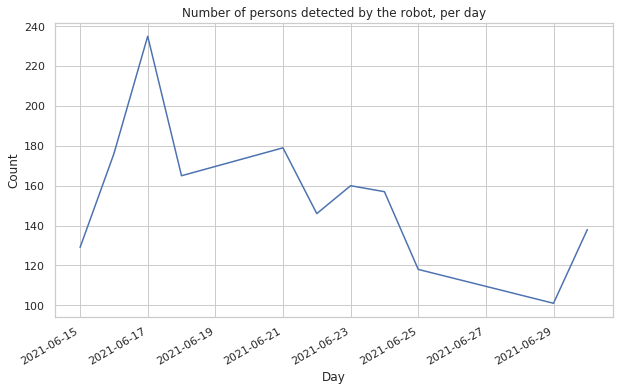

In [9]:
fig, ax = plt.subplots(figsize=(10, 6))

people.groupby("day").nunique().person_id.plot()

ax.set(xlabel="Day",
       ylabel="Count",
       title="Number of persons detected by the robot, per day")
pass

### How long children engaged with the robot

This is based on engagement as manually recorded by Joe during the study.

Group interactions are counted as 'one' (eg a group of 2 children interacting for 10min would count for 10min, not 20min)

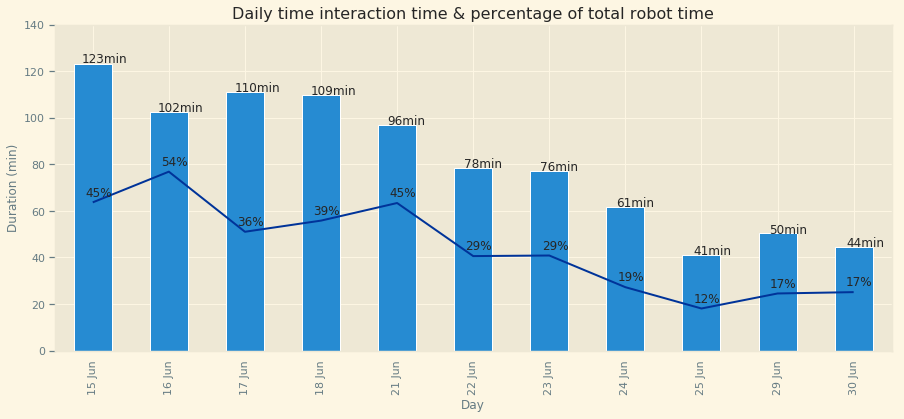

In [10]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))
    ax2 = ax.twinx()

    time_robot_on["in_interaction_min"]=time_robot_on.in_interaction/60
    time_robot_on.in_interaction_min.plot.bar(ax=ax, ylim=[0,140])   
    time_robot_on.percentage_in_interaction.plot.line(ax=ax2,color="#003399",use_index=False,ylim=[0,100])  
    
    
    ax.set(xlabel="Day",
           ylabel="Duration (min)",
           title="Daily time interaction time & percentage of total robot time")
    ax.xaxis.set_major_formatter(DATE_FORMATTER)
    
    ax2.grid(False)
    ax2.set_yticks([])
    
    for p in ax.patches:
        ax.annotate(str(int(p.get_height())) + "min", (p.get_x() * 1.005+0.1, p.get_height() * 1.005))

    for row in time_robot_on.reset_index()[['percentage_in_interaction']].iterrows():
        ax2.text(row[0]-0.1, 
                 row[1][0] + 2, 
                 str(int(row[1][0])) + "%");
    

pass

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


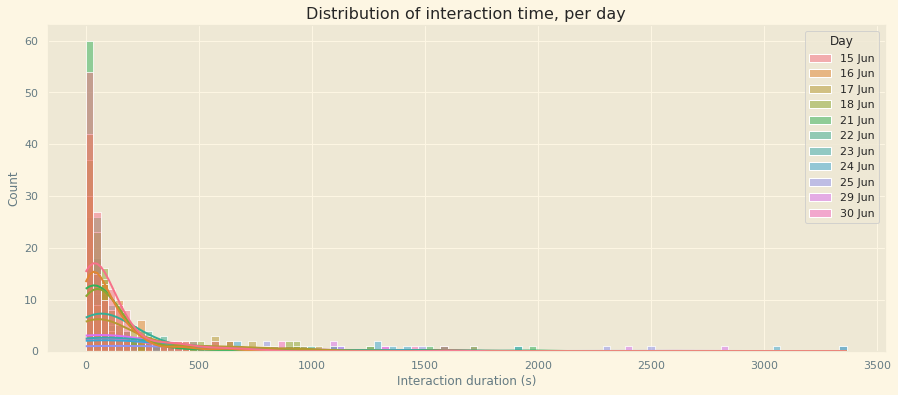

In [11]:

with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))

    sns.histplot(children, x="duration",hue="day",kde=True)

    ax.set(xlabel="Interaction duration (s)",
           ylabel="Count",
           title="Distribution of interaction time, per day")
   

    handles = plt.gca().get_legend().legendHandles
    texts = plt.gca().get_legend().get_texts()
    ax.legend(handles,[pd.Timestamp(t.get_text()).strftime("%d %b") for t in texts], title="Day", fancybox=True)
pass

/usr/lib/python3/dist-packages/matplotlib/cbook/__init__.py:1402: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  ndim = x[:, None].ndim
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:276: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  x = x[:, np.newaxis]
/usr/lib/python3/dist-packages/matplotlib/axes/_base.py:278: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  y = y[:, np.newaxis]


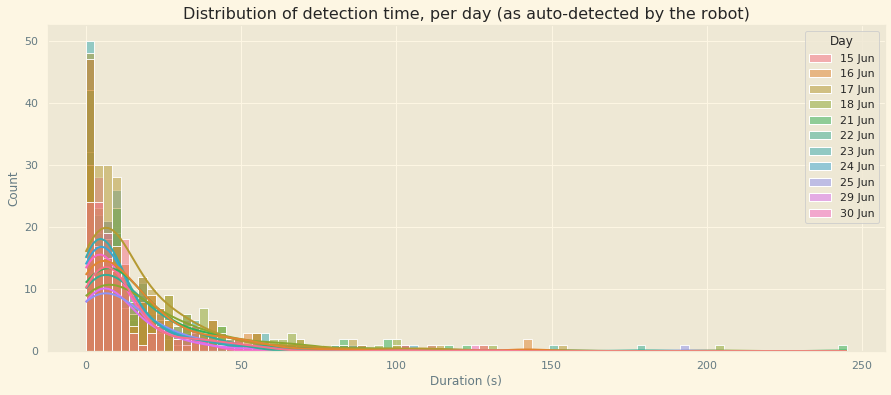

In [12]:
detection_time = (people.groupby(["day", "person_id"])["timeofday"].max() - people.groupby(["day", "person_id"])["timeofday"].min()).astype('timedelta64[s]').reset_index()
detection_time.rename(columns={"timeofday":"duration"}, inplace=True)

# filter out ouliers
#interaction_time = interaction_time[interaction_time.duration < 10000]

with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))

    sns.histplot(detection_time, x="duration",hue="day",kde=True)

    ax.set(xlabel="Duration (s)",
           ylabel="Count",
           title="Distribution of detection time, per day (as auto-detected by the robot)")
    
    handles = plt.gca().get_legend().legendHandles
    texts = plt.gca().get_legend().get_texts()
    ax.legend(handles,[pd.Timestamp(t.get_text()).strftime("%d %b") for t in texts], title="Day", fancybox=True)
pass

# Where were the people?

In [13]:
#_ = sns.scatterplot(data=people, x="x", y="y", hue=people.looking_at_robot).set_title("Location of people seen by the robot")

In [14]:
#fig, ax = plt.subplots(figsize=(10,10))
#_ = people.groupby("person_id").plot.line("x", "y", ax=ax,legend=False,title="Paths of tracked people")

In [15]:
#fig, ax = plt.subplots(figsize=(10,10))
#_ = users.groupby("user_id").plot.line("x", "y", ax=ax,legend=False, title="Paths of recognised people")

# How many children interacted with the robot?

### Raw data: number of children engaged with the robot over time

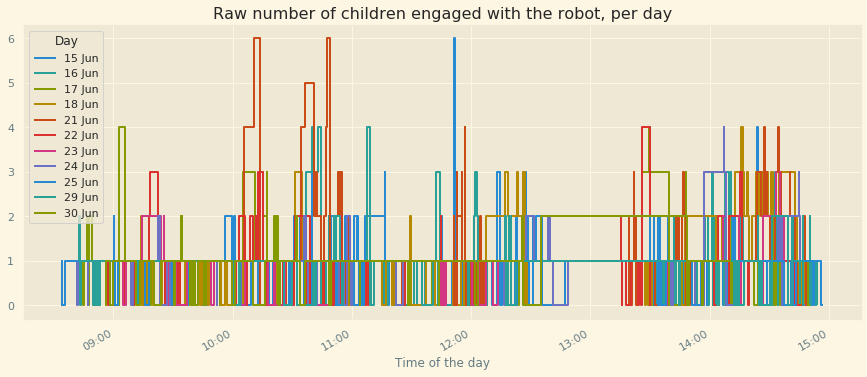

In [16]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))
    # Define the date format
    date_form = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    children.set_index("timeofday").groupby("day").nb_children.plot(drawstyle='steps-pre', legend=True)

    ax.set(xlabel="Time of the day",
           title="Raw number of children engaged with the robot, per day")
    
    handles = plt.gca().get_legend().legendHandles
    texts = plt.gca().get_legend().get_texts()
    ax.legend(handles,[pd.Timestamp(t.get_text()).strftime("%d %b") for t in texts], title="Day", fancybox=True)
pass

### Cumulative sum of children interacting with the robot

In [17]:
children["increase"] = children.nb_children.diff().fillna(0).clip(0)
children["cumsum"] = children.groupby("day").increase.cumsum()

In [18]:
children["cumsum"]

time
2021-06-15 09:37:07.606162944     0.0
2021-06-15 09:37:11.284563968     0.0
2021-06-15 09:37:25.642936832     1.0
2021-06-15 09:37:34.114775040     1.0
2021-06-15 09:44:44.870235904     2.0
2021-06-15 09:47:40.385935104     2.0
2021-06-15 09:48:30.875675904     3.0
2021-06-15 09:56:06.147011072     3.0
2021-06-15 09:59:50.180205056     4.0
2021-06-15 10:00:26.163842048     4.0
2021-06-15 10:01:01.372039936     5.0
2021-06-15 10:01:52.536417024     5.0
2021-06-15 10:03:19.623069952     5.0
2021-06-15 10:05:50.094914816     6.0
2021-06-15 10:09:04.058482944     6.0
2021-06-15 10:18:21.181902848     7.0
2021-06-15 10:20:05.311429888     7.0
2021-06-15 10:28:17.627078912     8.0
2021-06-15 10:30:39.193398016     8.0
2021-06-15 10:30:42.767809024     9.0
2021-06-15 10:33:45.991910912    10.0
2021-06-15 10:33:50.782953984    10.0
2021-06-15 10:35:37.582766080    11.0
2021-06-15 10:35:43.724347136    11.0
2021-06-15 10:35:57.037403136    11.0
2021-06-15 10:37:12.087596032    12.0
2021-06

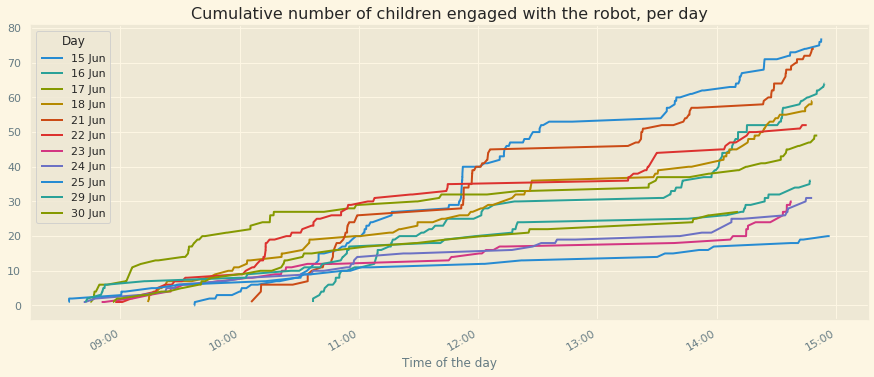

In [19]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))
    # Define the date format
    date_form = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    children.set_index("timeofday").groupby("day")["cumsum"].plot(legend=True)

    ax.set(xlabel="Time of the day",
           title="Cumulative number of children engaged with the robot, per day")
    
    handles = plt.gca().get_legend().legendHandles
    texts = plt.gca().get_legend().get_texts()
    ax.legend(handles,[pd.Timestamp(t.get_text()).strftime("%d %b") for t in texts], title="Day", fancybox=True)
pass

### Computation of # of children interacting with the robot in a given time window

In a given time window, the number of interacting children is equal to the number of children interacting with the robot when the window starts + the sum of children joining the interaction over the window. For instance:
  - t0: 2 children present
  - t1: 1 child present
  - t3: 2 children present -> 1 child joined
  - t4: 4 children present -> 2 more children joined
  
  => 2 + 1 + 2 = 5 children who interacted with the robot during that time window
  
This computation is performed independently for each day.
 

In [20]:
children=children.reset_index().set_index("timeofday")

WINDOW="10min"

windows=pd.date_range(pd.Timestamp(0) + pd.Timedelta("08:30:00"), pd.Timestamp(0) + pd.Timedelta("15:15:00"), freq=WINDOW)
d = {'timeofday':[], 'interacting_children':[]}

def interacting_children_per_day(children):
    
    for i in range(len(windows)-1):

        # if no logs at that time, record 0 child and continue
        if windows[i] < children.index[0] or windows[i] > children.index[-1]:
            d['timeofday'].append(windows[i])
            d['interacting_children'].append(0)
            continue

        if i > 1:
            try:
                initial_nb_children = children[windows[i-1]:windows[i]].iloc[-1].nb_children
            except IndexError:
                initial_nb_children = 0    
        else:
            initial_nb_children = 0

        sum_increase = children[windows[i]:windows[i+1]].increase.sum()

        total_interacting_children = initial_nb_children + sum_increase
        
        d['timeofday'].append(windows[i])
        d['interacting_children'].append(total_interacting_children)

    df = pd.DataFrame(data=d)
    df = df.set_index('timeofday')
    return df

interacting_children = children.groupby("day").apply(interacting_children_per_day)
interacting_children.reset_index(inplace=True)


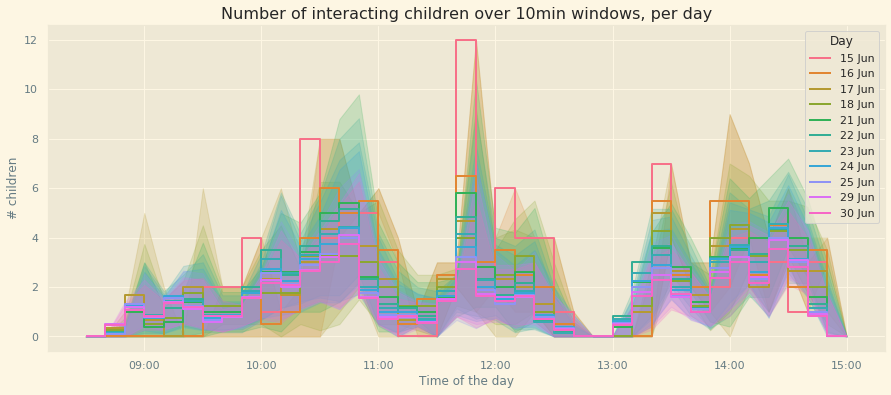

In [21]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))
    # Define the date format
    date_form = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    sns.lineplot(data=interacting_children,y="interacting_children",x="timeofday",hue="day", drawstyle="steps-pre")

    ax.set(xlabel="Time of the day",
           ylabel="# children",
           title="Number of interacting children over %s windows, per day" % WINDOW)
    
        
    handles = plt.gca().get_legend().legendHandles
    texts = plt.gca().get_legend().get_texts()
    ax.legend(handles,[pd.Timestamp(t.get_text()).strftime("%d %b") for t in texts], title="Day", fancybox=True)
pass

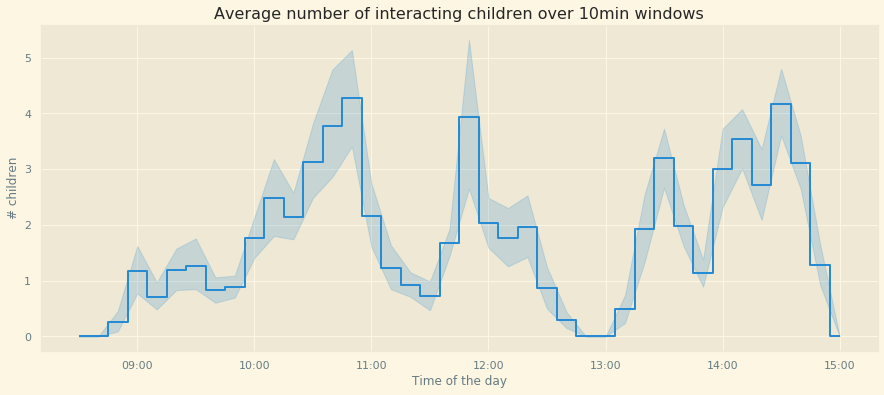

In [22]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))
    # Define the date format
    date_form = DateFormatter("%H:%M")
    ax.xaxis.set_major_formatter(date_form)

    sns.lineplot(data=interacting_children,y="interacting_children",x="timeofday",drawstyle="steps-mid")

    ax.set(xlabel="Time of the day",
           ylabel="# children",
           title="Average number of interacting children over %s windows" % WINDOW)
pass

In [23]:
d={"day":[], "nb_children": [], "duration":[]}

i = 0
nb_children = 0
start_time = None
while True:
    if i == len(children):
        break
       
    row = children.iloc[i]

    if row.nb_children > 0:
        if not start_time:
            start_time = row.name
        nb_children = max(nb_children, row.nb_children)
    else:
        d["day"].append(row.day)
        d["nb_children"].append(nb_children if nb_children < 6 else "6+")
        d["duration"].append(row.name - start_time)
        start_time = 0
        nb_children = 0
    
    i += 1
    

interactions_group = pd.DataFrame(d)
interactions_group["duration"] = interactions_group.duration.astype("timedelta64[s]")
interactions_group

,day,nb_children,duration
0,2021-06-15,1,3.0
1,2021-06-15,1,8.0
2,2021-06-15,1,175.0
3,2021-06-15,2,888.0
4,2021-06-15,1,193.0
5,2021-06-15,1,104.0
6,2021-06-15,1,141.0
7,2021-06-15,2,314.0
8,2021-06-15,1,46.0
9,2021-06-15,3,163.0


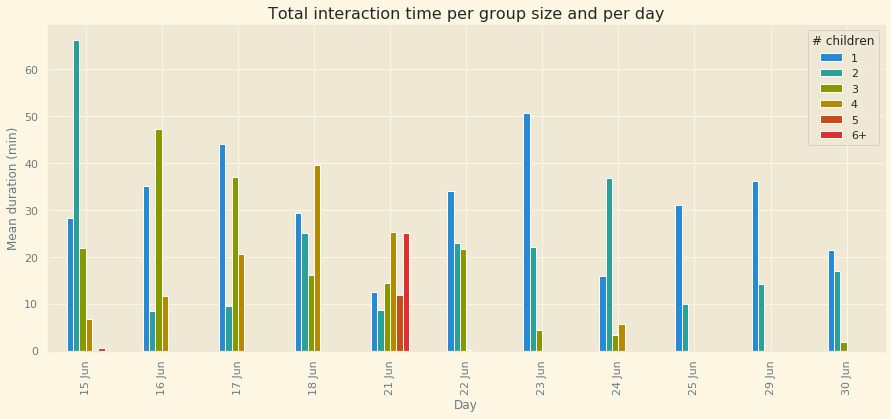

In [24]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))


    df=interactions_group.groupby(["day", "nb_children"]).duration.sum().to_frame().reset_index()
    df["duration_min"]=df.duration/60

    df.set_index(["day","nb_children"]).duration_min.unstack(1).plot.bar(ax=ax)


    ax.xaxis.set_major_formatter(DATE_FORMATTER)

    ax.set(xlabel="Day",
           ylabel="Mean duration (min)",
           title="Total interaction time per group size and per day")

    ax.legend(title="# children", fancybox=True)

pass

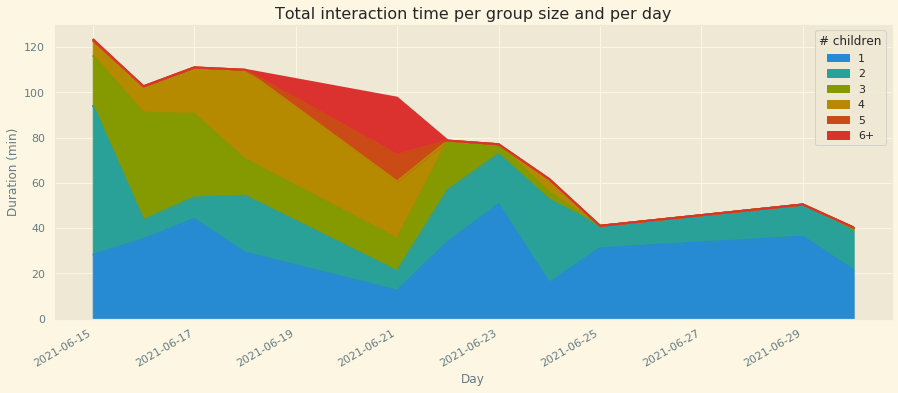

In [25]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))

    df=interactions_group.groupby(["day", "nb_children"]).duration.sum().to_frame().reset_index()
    df["duration_min"]=df.duration/60

    df.set_index(["day", "nb_children"])["duration_min"].unstack(1).plot.area(ax=ax)

    # Define the date format
    #date_form = DateFormatter("%d")
    #ax.xaxis.set_major_formatter(date_form)

    ax.set(xlabel="Day",
           ylabel="Duration (min)",
           title="Total interaction time per group size and per day")

    ax.legend(title="# children", fancybox=True)
pass

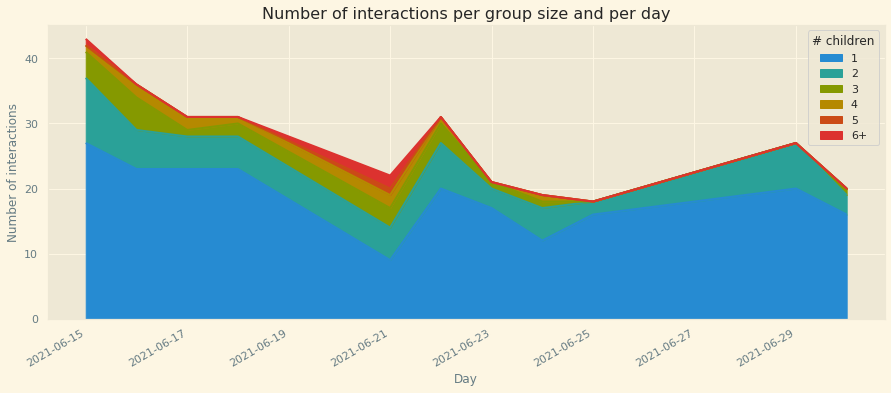

In [26]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))

    df=interactions_group.groupby(["day", "nb_children"]).count()
    df.unstack(1).droplevel(0, axis=1).plot.area(ax=ax)

    # Define the date format
    #date_form = DateFormatter("%d %b")
    #ax.xaxis.set_major_formatter(date_form)

    ax.set(xlabel="Day",
           ylabel="Number of interactions",
           title="Number of interactions per group size and per day")
    
    ax.legend(title="# children", fancybox=True)

pass

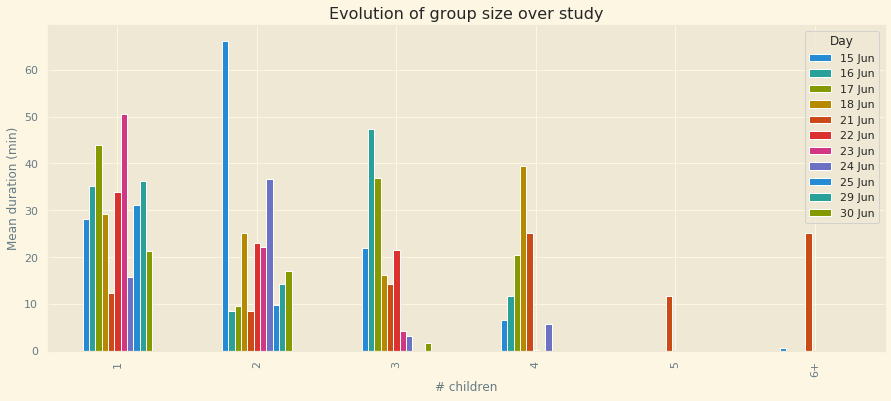

In [27]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))

    df=interactions_group.groupby(["day", "nb_children"]).duration.sum().to_frame().reset_index()
    df["duration_min"]=df.duration/60

    df.groupby(["day", "nb_children"]).duration_min.sum().unstack(0).plot.bar(ax=ax)

    ax.set(xlabel="# children",
           ylabel="Mean duration (min)",
           title="Evolution of group size over study")

    

    handles = plt.gca().get_legend().legendHandles
    texts = plt.gca().get_legend().get_texts()
    ax.legend(handles,[pd.Timestamp(t.get_text()).strftime("%d %b") for t in texts], title="Day", fancybox=True)
pass

# Activities

In [28]:
acts = actions.reset_index()
acts = acts[~acts.status.str.contains("mood")]
acts = acts[~acts.status.str.contains("unknown")]
acts = acts[acts.activity != "default"]

d={"day":[], "timeofday":[], "activity":[], "duration":[]}

for i in range(len(acts)-1):

    row = acts.iloc[i]
    row_n = acts.iloc[i+1]
    if row["status"] == "running":
        if row_n["status"] == "running":
            continue
        d["timeofday"].append(row.timeofday)
        d["day"].append(row.day)
        d["activity"].append(row.activity)
        d["duration"].append((row_n.timeofday-row.timeofday))
    
activities = pd.DataFrame(d)
activities["duration"] = activities.duration.astype('timedelta64[100ms]')/10

In [31]:
activities_count = activities[activities.activity != "mood board"].groupby(["day","activity"]).count().reset_index()
#activities_count["calm"] = activities_count[activities_count["activity"calm dances"] + activities_count["calm music"] + activities_count["relaxing sounds"]
#activities_count[activities_count["activity"].isin(["calm dances", "calm music", "relaxing sounds"])].groupby("day").sum().reset_index()["activity"] ==

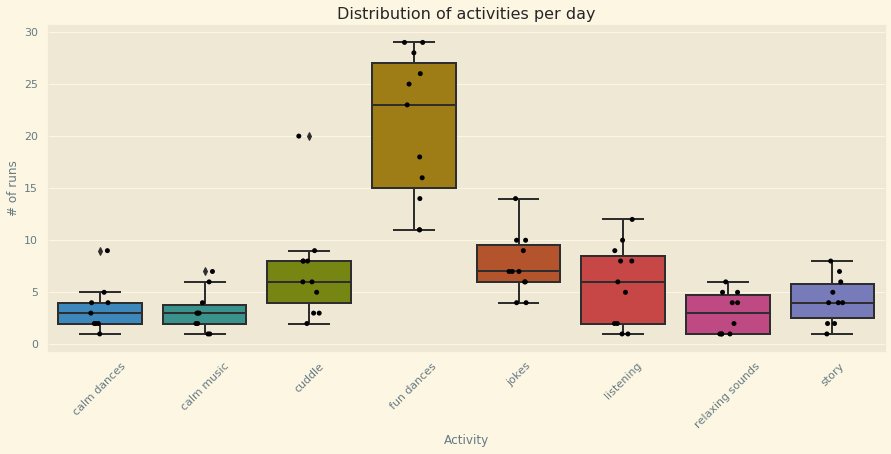

In [33]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))

    sns.boxplot(data=activities_count,x="activity",y="duration", ax=ax)
    sns.stripplot(data=activities_count,x="activity",y="duration", color='black', ax=ax)

    ax.set(xlabel="Activity",
           ylabel="# of runs",
           title="Distribution of activities per day")

    plt.xticks(rotation=45)

In [53]:

activities["gender"] = np.random.choice(("M", "F"),activities.shape[0])
activities

from scipy.stats import ttest_ind

cat1 = activities[(activities['activity']=='fun dances') & (activities['gender']=='M')]
cat2 = activities[(activities['activity']=='fun dances') & (activities['gender']=='F')]

print(cat1.duration.mean())
print(cat2.duration.mean())
print(ttest_ind(cat1['duration'], cat2['duration']))
activities[(activities['activity']=='fun dances')].groupby("gender").describe()


28.429357798165142
29.0297520661157
Ttest_indResult(statistic=-0.23839780067862235, pvalue=0.8117866960032903)


duration                                                    
          count       mean        std   min   25%   50%   75%   max
gender                                                             
F         121.0  29.029752  18.502323  12.2  13.2  20.2  55.8  59.7
M         109.0  28.429358  19.683859   9.3  13.1  19.3  55.8  99.7

In [ ]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))

    sns.barplot(data=activities_count,hue='day',x="activity",y="duration")

    ax.set(xlabel="Activity",
           ylabel="# of runs",
           title="Activity runs per day")

    handles = plt.gca().get_legend().legendHandles
    texts = plt.gca().get_legend().get_texts()
    ax.legend(handles,[pd.Timestamp(t.get_text()).strftime("%d %b") for t in texts], title="Day", fancybox=True)
    
    plt.xticks(rotation=45)
pass

In [ ]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))

    sns.barplot(data=activities,x="activity",y="duration")

    ax.set(xlabel="Activity",
           ylabel="Duration (min)",
           title="Mean duration of activities")
    ax.yaxis.set_major_formatter(tick.FuncFormatter(lambda x,p: pd.Timestamp(x,unit='s').strftime("%M:%S")))

    plt.xticks(rotation=45)
pass

## Total time spent in the different activities

Total interaction time with the robot:

In [ ]:
#time_robot_on["in_interaction"]=pd.to_timedelta(time_robot_on.in_interaction,unit="s")
time_robot_on

In [ ]:
pd.to_timedelta(activities.groupby("activity").duration.sum(),unit="s").sum()

In [ ]:
#activities["duration"] = pd.to_timedelta(activities.duration,unit="s")
pd.Timedelta(activities.duration.sum(), unit="s")

Interaction time per day:

In [ ]:
interaction_time_per_day = pd.to_timedelta(activities.groupby("day").duration.sum(), unit="s")
interaction_time_per_day

In [ ]:
with plt.style.context('Solarize_Light2'):
    fig, ax = plt.subplots(figsize=(15, 6))
    
    interaction_time_per_day.astype("timedelta64[m]").plot(ax=ax)
    
    ax.set(xlabel="Day",
           ylabel="Duration (min)",
           title="Total time spent in activity per day")
        

### Interaction time per activity

In [ ]:
activities.groupby(["day", "activity"]).duration.sum().to_frame()

In [ ]:
with plt.style.context('Solarize_Light2'):
    
    fig, ax = plt.subplots(figsize=(15, 6))


    df=activities.groupby(["day", "activity"]).duration.sum().to_frame().reset_index()
    df["duration_min"]=df.duration/60

    sns.barplot(data=df, y="duration_min", x="activity", hue="day")

    ax.set(xlabel="Activity",
           ylabel="Total duration (min)",
           title="Total time spent on each activity, per day")

    plt.xticks(rotation=45)
    
    handles = plt.gca().get_legend().legendHandles
    texts = plt.gca().get_legend().get_texts()
    ax.legend(handles,[pd.Timestamp(t.get_text()).strftime("%d %b") for t in texts], title="Day", fancybox=True)
pass


# Mood analysis

In [ ]:
moods

Preparing the data for the Sankey plot

In [ ]:
df = moods.copy()
df["initial_mood"] = moods.initial_mood.replace("mood_green",0).replace("mood_blue",1).replace("mood_yellow",2).replace("mood_red",3).replace(["yes","no","unknown"],4)
df["final_mood"] = moods.final_mood.replace("mood_green",5).replace("mood_blue",6).replace("mood_yellow",7).replace("mood_red",8).replace(["yes","no","unknown"],9)
del df["activities"]
del df["end_type"]
df["count"] = df.nb_children
del df["nb_children"]
df

In [ ]:
moods_count=df.groupby(["initial_mood","final_mood"]).count()
moods_count["colour"] = "#9e9e9e22"
moods_count.loc[(0,9), "colour"] = "#58685199"
moods_count.loc[(1,9), "colour"] = "#515c6899"
moods_count.loc[(2,9), "colour"] = "#68675199"
moods_count.loc[(3,9), "colour"] = "#68535199"
moods_count.loc[(4,9), "colour"] = "#9e9e9e99"

moods_count.loc[(0,5), "colour"] = "#91b665"
moods_count.loc[(4,5), "colour"] = "#91b66599"
moods_count.loc[(0,8), "colour"] = "#b66865"
moods_count.loc[(0,6), "colour"] = "#658cb6"
moods_count.loc[(0,7), "colour"] = "#b6a965"

moods_count.loc[(1,6), "colour"] = "#658cb6"
moods_count.loc[(4,6), "colour"] = "#658cb699"
moods_count.loc[(1,8), "colour"] = "#b66865"
moods_count.loc[(1,5), "colour"] = "#91b665"
moods_count.loc[(1,7), "colour"] = "#b6a965"

moods_count.loc[(2,7), "colour"] = "#b6a965"
moods_count.loc[(4,7), "colour"] = "#b6a96599"
moods_count.loc[(2,8), "colour"] = "#b66865"
moods_count.loc[(2,5), "colour"] = "#91b665"
moods_count.loc[(2,6), "colour"] = "#658cb6"

moods_count.loc[(3,8), "colour"] = "#b66865"
moods_count.loc[(4,8), "colour"] = "#b6686599"
moods_count.loc[(3,5), "colour"] = "#91b665"
moods_count.loc[(3,6), "colour"] = "#658cb6"
moods_count.loc[(3,7), "colour"] = "#b6a965"

#moods_count.moods_count
moods_count.reset_index(inplace=True)

In [ ]:
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

# Nodes & links
nodes = [['ID', 'Label', 'Color'],
        [0,'Happy','#91b665'],
        [1,'Sad','#658cb6'],
        [2,'Frustrated','#b6a965'],
        [3,'Angry','#b66865'],
        [4,'Not recorded (group interaction)','#CCCCCC'],
        [5,'Happy','#91b665'],
        [6,'Sad','#658cb6'],
        [7,'Frustrated','#b6a965'],
        [8,'Angry','#b66865'],
        [9,'Not recorded (group or left early)','#CCCCCC'],]


# Retrieve headers and build dataframes
nodes_headers = nodes.pop(0)
df_nodes = pd.DataFrame(nodes, columns = nodes_headers)

# Sankey plot setup
data_trace = dict(
    type='sankey',
    domain = dict(
      x =  [0,1],
      y =  [0,1]
    ),
    orientation = "h",
    valueformat = ".0f",
    node = dict(
      pad = 10,
    # thickness = 30,
      line = dict(
        color = "black",
        width = 0
      ),
      label =  df_nodes['Label'].dropna(axis=0, how='any'),
      color = df_nodes['Color']
    ),
    link = dict(
      source = moods_count.initial_mood,
      target = moods_count.final_mood,
      value = moods_count["count"],
      color= moods_count.colour
  )
)

layout = dict(
        title = "Changes of mood after interactions",
    height = 772,
    font = dict(
      size = 16),
    paper_bgcolor='#fdf6e3',
    plot_bgcolor='#fdf6e3'
)

fig = dict(data=[data_trace], layout=layout)

config = {
  'toImageButtonOptions': {
    'format': 'png', # one of png, svg, jpeg, webp
    'filename': 'moods',
    'height': 450*2,
    'width': 874*2,
    'scale': 1 # Multiply title/legend/axis/canvas sizes by this factor
  }
}

iplot(fig, config=config,validate=False)
